<a href="https://colab.research.google.com/github/Craig-UK/artificial-intelligence/blob/main/StockPreBasedOffModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [261]:
!pip install pystan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [262]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [263]:
import pandas as pd
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as web

start = dt.datetime(2020, 1, 1)
end = dt.datetime.now()

data = web.get_data_yahoo("ATVI", start, end)

data.to_csv("stock_data.csv")

[*********************100%***********************]  1 of 1 completed


In [264]:
data = pd.read_csv("stock_data.csv")

In [265]:
data = data[["Date", "Close"]]

In [266]:
data

,Date,Close
0,2020-01-02,58.650002
1,2020-01-03,58.669998
2,2020-01-06,59.740002
3,2020-01-07,60.340000
4,2020-01-08,59.880001
...,...,...
812,2023-03-24,84.389999
813,2023-03-27,84.330002
814,2023-03-28,84.349998
815,2023-03-29,84.540001


In [267]:
data.columns = ["ds", "y"]

In [268]:
data

,ds,y
0,2020-01-02,58.650002
1,2020-01-03,58.669998
2,2020-01-06,59.740002
3,2020-01-07,60.340000
4,2020-01-08,59.880001
...,...,...
812,2023-03-24,84.389999
813,2023-03-27,84.330002
814,2023-03-28,84.349998
815,2023-03-29,84.540001


In [269]:
from prophet import Prophet

In [270]:
prophet = Prophet(daily_seasonality=True)
prophet.fit(data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqjgsgay_/sp4vaa9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqjgsgay_/u92wal2z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48713', 'data', 'file=/tmp/tmpqjgsgay_/sp4vaa9z.json', 'init=/tmp/tmpqjgsgay_/u92wal2z.json', 'output', 'file=/tmp/tmpqjgsgay_/prophet_modeljw39c4j2/prophet_model-20230330174252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [271]:
future_dates = prophet.make_future_dataframe(periods=30)
predictions = prophet.predict(future_dates)

In [272]:
from prophet.plot import plot_plotly

plot_plotly(prophet, predictions)

In [273]:
pred_month = predictions["yhat"][-30:]

In [274]:
old_arr = []
full_arr = []
for x in pred_month:
  old_arr.append(x)
old_arr
for x in predictions["yhat"][-120:]:
  full_arr.append(x)
full_arr

[69.2972246868178,
 68.9035328462015,
 68.80304857339495,
 68.63107307954874,
 68.70750440721557,
 68.88545491554032,
 68.98311804731253,
 69.00941764499332,
 69.20905837154416,
 69.47371769316487,
 70.17889929360022,
 70.42972576425672,
 70.59503137666323,
 70.91812371874111,
 71.28953557750093,
 72.20749805925563,
 72.49245977639573,
 72.67376095297004,
 72.99529462365756,
 73.34844798036013,
 74.12354386514947,
 74.33654460944453,
 74.4366059950454,
 74.66950520765891,
 74.92855937709065,
 75.52366102354996,
 75.5301951435629,
 75.67456944575721,
 75.85136734791585,
 76.19835025730842,
 76.16576929151867,
 76.28053028102805,
 76.43703922852092,
 76.70754123096661,
 76.78694631589725,
 76.77273842405562,
 76.91128310484743,
 77.09608752781273,
 77.5866283753423,
 77.61037352348292,
 77.78658273544085,
 78.00819623896682,
 78.48259900655745,
 78.6289300039293,
 78.67947654479451,
 78.87979368421247,
 79.12268767585891,
 79.64272239986914,
 79.7977080350139,
 79.85330732864966,
 80.054

In [275]:
import numpy as np, numpy.random
value = np.random.dirichlet((9.5, 0.5), 30).transpose()

values = np.sort(value[0])
same_one = []

for i,x in enumerate(pred_month):
  if i == 0:
    same_one.append(x)
  else:
    same_one.append(x + values[i])
same_one
original_values = full_arr.copy()
full_arr[-30:] = same_one
print(value[0])
print(values)

[0.9982912  0.86359322 0.99706508 0.98273114 0.9890808  0.98191526
 0.89965971 0.93619664 0.96878305 0.99990447 0.99886573 0.99886882
 0.95715126 0.36044278 0.98419994 0.89031269 0.90516777 0.98540007
 0.99936594 0.89946818 0.93178694 0.9853241  0.99337357 0.9880106
 0.98298715 0.86287399 0.94930317 0.99977968 0.99982377 0.96399219]
[0.36044278 0.86287399 0.86359322 0.89031269 0.89946818 0.89965971
 0.90516777 0.93178694 0.93619664 0.94930317 0.95715126 0.96399219
 0.96878305 0.98191526 0.98273114 0.98298715 0.98419994 0.9853241
 0.98540007 0.9880106  0.9890808  0.99337357 0.99706508 0.9982912
 0.99886573 0.99886882 0.99936594 0.99977968 0.99982377 0.99990447]


<Axes: >

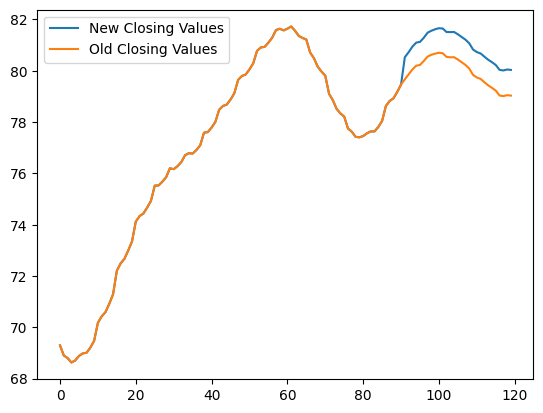

In [276]:
new_preds = pd.DataFrame(full_arr, columns = ["New Closing Values"])
old_preds = pd.DataFrame(original_values, columns = ["Old Closing Values"])
df_merged = pd.concat([new_preds, old_preds], axis=1)
df_merged
df_merged.plot()

In [285]:
from sklearn.metrics import accuracy_score
start = dt.datetime(2020, 1, 1)
end = dt.datetime.now()
data = web.get_data_yahoo("ATVI", start, end)
data.to_csv("stock_data.csv")
data = pd.read_csv("stock_data.csv")
print(data)
data = data[["Date", "Close"]]
prophet = Prophet(daily_seasonality=True)
data.columns = ["ds", "y"]
prophet.fit(data[:-100])
future_dates = prophet.make_future_dataframe(periods=100)
predictions = prophet.predict(future_dates)
plot_plotly(prophet, predictions)
real = data["y"][-100:]
predict = predictions["yhat"][-100:]
if sum(real) > sum(predict):
  total = ((sum(real) - sum(predict)) / sum(real)) * 100
  #print(total)
else:
  total = ((sum(predict) - sum(real)) / sum(predict)) * 100
  #print(total)
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
print(smape(real, predict))

[*********************100%***********************]  1 of 1 completed
           Date       Open       High        Low      Close  Adj Close  \
0    2020-01-02  59.910000  60.049999  58.560001  58.650002  57.643394   
1    2020-01-03  58.029999  58.930000  57.650002  58.669998  57.663044   
2    2020-01-06  58.470001  59.869999  58.439999  59.740002  58.714684   
3    2020-01-07  59.689999  60.410000  59.209999  60.340000  59.304386   
4    2020-01-08  60.000000  60.889999  59.849998  59.880001  58.852280   
..          ...        ...        ...        ...        ...        ...   
812  2023-03-24  84.839996  85.720001  83.320000  84.389999  84.389999   
813  2023-03-27  84.120003  84.930000  84.080002  84.330002  84.330002   
814  2023-03-28  84.500000  84.750000  84.040001  84.349998  84.349998   
815  2023-03-29  84.389999  84.599998  84.150002  84.540001  84.540001   
816  2023-03-30  84.750000  85.099998  84.625000  84.849998  84.849998   

       Volume  
0     5189400  
1     4466

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqjgsgay_/cw0r03uh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqjgsgay_/o3_0x17l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76252', 'data', 'file=/tmp/tmpqjgsgay_/cw0r03uh.json', 'init=/tmp/tmpqjgsgay_/o3_0x17l.json', 'output', 'file=/tmp/tmpqjgsgay_/prophet_modelarmhzbsc/prophet_model-20230330175417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


7.04586605986387
